In [1]:
# only for this notebook
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

#### The script functions

In [2]:
import cftime
import numpy as np
import datetime
import time
import glob, os
import sys
import math
import netCDF4 as netcdf
import multiprocessing as mp

dry_run			= False # set False to do computing

#-----------------------------------------------------------------------------------------------------------------
# uncomment for RCP8.5 hres data
run_ensemble	= 1 # ensemble number must be provided as script argument
run_year_start	= 2092 # [2002, 2092]
experiment_name = 'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_'+str(run_year_start)+'-12.'+str(run_ensemble).zfill(3)
directory_data  = f'/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/{experiment_name}/OUTPUT/atm/hist/3h/'
stream		  	= 'h1'
directory		= f'/home/jasperdj/files_rene/RCP.started_{run_year_start}.{run_ensemble:03d}.test/'
gridfile		= '/home/jasperdj/files_rene/Atmosphere_0_25_DX_DY_AREA.nc'
NOUT			= 8 # number of time steps per output file (one day)

# # uncomment for SAI hres data
# run_ensemble	= sys.argv[1] # ensemble number must be provided as script argument
# run_year_start	= 2092 # [2092]
# experiment_name = 'hres_b.e10.B2000_CAM5.f02_t12.started_'+str(run_year_start)+'-12.'+str(run_ensemble).zfill(3)
# directory_data  = '/projects/0/nwo2021025/archive/'+experiment_name+'/atm/hist/'
# stream		  	= 'h5'
# directory		= '/home/jasperdj/files_rene/SAI.started_'+str(run_year_start)+'.'+str(run_ensemble).zfill(3)+'/'
# gridfile		= '/home/jasperdj/files_rene/Atmosphere_0_25_DX_DY_AREA.nc'
# NOUT			= 8 # number of time steps per output file (one day)

# # uncomment for SAI mres (0.5degree) data
# experiment_name = 'mres_b.e10.B2000_CAM5.f05_t12.001'
# directory_data	= '/projects/0/nwo2021025/archive/'+experiment_name+'/atm/hist/'
# stream			= 'h4'
# stream3D		= 'h3' # only used for mres to calculate U250, V250 and T850
# directory		= '/home/jasperdj/files_rene/SAI.mres/'
# gridfile		= '/home/jasperdj/files_rene/Atmosphere_0_5_DX_DY_AREA.nc'
# NOUT			= 4 # number of time steps per output file (one day)
#-----------------------------------------------------------------------------------------------------------------

# input data
files = glob.glob(directory_data+experiment_name+'.cam2.'+stream+'.*.nc')
files.sort() #Sort the files on date

LATMIN = -60
LATMAX = 60 
RADIUSEARTH=6371000.0
RVTHRESHOLD=6.0 * 10**(-5.0) # minimum for RV@850hPa
RVDIFFTHRESHOLD=6.0 * 10**(-5.0) # minimum for RV@850hPa - RV@250hPa
CORETEMPTHRESHOLD=0.0 # minimum temperature anomaly core w.r.t. 8x8 degree area
FIELDSIZE=8 # (degrees N x E) size of field to calculate reference temperature
U10THRESHOLD=10 # (m/s) minimum 10m wind speed
U10THRESHOLD_MAXRADIUS=100 # (km) U10 should be 10m/s within 100km
RVDISTMIN=250 # (km) min. distance between maxima (if less, only the one with lower PSL counts)


def chunk_data(files):
	"""divide data into daily chunks"""
	n = 0 
# 	dt = 1/NOUT # output time step in days
	with netcdf.Dataset(files[0],'r') as fh:
		time = fh.variables['time'][:]
		if 'time: mean' in getattr(fh['U850'], 'cell_methods', ''):
			time = time - 0.5*dt
		dates = [cftime.num2date(t, fh['time'].units, fh['time'].calendar).strftime("%Y%m%d") for t in time]
		chunks = [[dates[0],[0],0,0]]
	for fid in range(len(files)):
		with netcdf.Dataset(files[fid],'r') as fh:
			time = fh.variables['time'][:]
			if 'time: mean' in getattr(fh['U850'], 'cell_methods', ''):
				time = time - 0.5*dt
			dates = [cftime.num2date(t, fh['time'].units, fh['time'].calendar).strftime("%Y%m%d") for t in time]
			for i,newdate in enumerate(dates):
				(olddate, fids0, i0, n0) = chunks[-1]
				if newdate != olddate:
					if fids0[-1] != fid and i!=0:
						chunks[-1][1].append(fid)
					chunks[-1][3] = i0 + n - n0
					chunks.append([newdate,[fid],i,n])
				n += 1
	(olddate, fids0, i0, n0) = chunks[-1]
	chunks[-1][3] = i0 + n - n0
	return chunks


# # old version
# def chunk_data(files):
# 	"""divide data into daily chunks"""
# 	n = 0
# 	with netcdf.Dataset(files[0],'r') as fh:
# 		Time = fh.variables['time']
# 		CTime = fh.variables['time_bnds'][:].mean(axis=1)
# 		dates = [cftime.num2date(T, Time.units, Time.calendar).strftime("%Y%m%d") for T in CTime]
# 		chunks = [[dates[0],[0],0,0]]
# 	for fid in range(len(files)):
# 		with netcdf.Dataset(files[fid],'r') as fh:
# 			CTime = fh.variables['time_bnds'][:].mean(axis=1)
# 			dates = [cftime.num2date(T, Time.units, Time.calendar).strftime("%Y%m%d") for T in CTime]
# 			for i,newdate in enumerate(dates):
# 				(olddate, fids0, i0, n0) = chunks[-1]
# 				if newdate != olddate:
# 					if fids0[-1] != fid and i!=0:
# 						chunks[-1][1].append(fid)
# 					chunks[-1][3] = i0 + n - n0
# 					chunks.append([newdate,[fid],i,n])
# 				n += 1
# 	(olddate, fids0, i0, n0) = chunks[-1]
# 	chunks[-1][3] = i0 + n - n0
# 	return chunks


def ReadinDataFixForMRES(filenames, t1, t2):
	"""The mres h4 file does not contain U250, V250 and T850, so using 3D data"""
	with netcdf.MFDataset(filenames, 'r', aggdim='time') as fh:
		time	   = fh.variables['time']				   #Time
		time	   = cftime.num2date(time[t1:t2], time.units, calendar=time.calendar)
		lon			= fh.variables['lon'][:]					# Longitude
		lat			= fh.variables['lat'][i1-1:i2+1]			# Latitude
		lat_weight	= fh.variables['gw'][i1:i2]				    # Latitude weight
		pres		= fh.variables['PSL'][t1:t2, i1:i2] / 100.0	# Sea level pressure (hPa)
		U_10		= fh.variables['U10'][t1:t2, i1:i2]		    # 10-meter wind speed (m/s)
		u_vel_850	= fh.variables['U850'][t1:t2, i1-1:i2+1]    # Zonal velocity at 850 hPa (m/s)
		v_vel_850	= fh.variables['V850'][t1:t2, i1-1:i2+1]    # Zonal velocity at 850 hPa (m/s)
	files3D = glob.glob(directory_data+experiment_name+'.cam2.'+stream3D+'.*.nc')
	files3D.sort() #Sort the files on date
	fidi = files3D.index(filenames[0].replace(f".{stream}.", f".{stream3D}."))
	for fid in range(fidi,len(files3D)):
		with netcdf.Dataset(files3D[fid], 'r') as fh:
			time3D = fh.variables['time']
			time3D = cftime.num2date(time3D[:],time3D.units,calendar=time3D.calendar)
		if time[0] in time3D:
			fid0 = fid
		if time[-1] in time3D:
			fid1 = fid
			break
	with netcdf.MFDataset(files3D[fid0:fid1+1], 'r', aggdim='time') as fh:
		time3D = fh.variables['time']
		time3D = cftime.num2date(time3D[:],time3D.units,calendar=time3D.calendar)
		ti, tf = time3D.searchsorted([time[0], time[-1]])
		assert all(time3D[ti:tf+1]==time), (
			f"Could not obtain steps {time=} from {time3D=} in {stream3D} output.")
		lev = fh.variables['lev'][:]
		assert max(lev) < 1200, f"cannot assume lev has units hPa (max: {max(lev)=})" # assume hPa unit
		l250 = abs(lev-250).argmin()
		l850 = abs(lev-850).argmin()
		print(f"Warning @ {[os.path.basename(f) for f in filenames]}\n  reading U, V at lev={lev[l250]:.1f}hPa, "
			+ f"T at lev={lev[l850]:.1f}hPa instead of true pressure levels.")
		temp = fh.variables['T'][ti:tf+1, l850, i1:i2]
		u_vel_250 = fh.variables['U'][ti:tf+1, l250, i1-1:i2+1]
		v_vel_250 = fh.variables['V'][ti:tf+1, l250, i1-1:i2+1]
		return time, lon, lat, lat_weight, pres, temp, U_10, u_vel_850, u_vel_250, v_vel_850, v_vel_250


def ReadinData(filenames, x_diff, y_diff, t1, t2):
	# if experiment_name == 'mres_b.e10.B2000_CAM5.f05_t12.001':
# 		(time, lon, lat, lat_weight, pres, temp, U_10, u_vel_850,
# 		u_vel_250, v_vel_850, v_vel_250) = ReadinDataFixForMRES(filenames, t1, t2)
# 	else:
	with netcdf.MFDataset(filenames, 'r', aggdim='time') as fh:
		time	   = fh.variables['time'][t1:t2]				   #Time
		if 'time: mean' in getattr(fh['U850'], 'cell_methods', ''):
			time = time - 0.5*dt
		time	   = cftime.num2date(time, fh['time'].units, fh['time'].calendar)
		lon		   = fh.variables['lon'][:]					   #Longitude
		lat		   = fh.variables['lat'][i1-1:i2+1]				 #Latitude
		lat_weight = fh.variables['gw'][i1:i2]				 #Latitude weight
		pres	   = fh.variables['PSL'][t1:t2, i1:i2] / 100.0	 #Sea level pressure (hPa)
		U_10	   = fh.variables['U10'][t1:t2, i1:i2]		 #10-meter wind speed (m/s)
		u_vel_850  = fh.variables['U850'][t1:t2, i1-1:i2+1]	 #Zonal velocity at 850 hPa (m/s)
		v_vel_850  = fh.variables['V850'][t1:t2, i1-1:i2+1]	 #Zonal velocity at 850 hPa (m/s)
		temp	   = fh.variables['T850'][t1:t2, i1:i2]		 #Temperature 850 hPa
		u_vel_250  = fh.variables['U250'][t1:t2, i1-1:i2+1]	 #Zonal velocity at 250 hPa (m/s)
		v_vel_250  = fh.variables['V250'][t1:t2, i1-1:i2+1]	 #Zonal velocity at 250 hPa (m/s)

	#Add periodic boundaries
	lon_2, u_vel_850	= PeriodicBoundaries3D(time, lon, lat, u_vel_850)
	lon_2, v_vel_850	= PeriodicBoundaries3D(time, lon, lat, v_vel_850)
	lon_2, u_vel_250	= PeriodicBoundaries3D(time, lon, lat, u_vel_250)
	lon, v_vel_250		= PeriodicBoundaries3D(time, lon, lat, v_vel_250)

	#Determine the vorticity at 850 and 250 hPa
	vor_850			= np.ma.masked_all((len(time), len(lat) - 2, len(lon) - 2))
	vor_250			= np.ma.masked_all((len(time), len(lat) - 2, len(lon) - 2))

	for time_i in range(len(time)):
		#Vorticity for the two level
		vor_850[time_i] = RelativeVorticity(u_vel_850[time_i], v_vel_850[time_i], x_diff, y_diff)
		vor_250[time_i] = RelativeVorticity(u_vel_250[time_i], v_vel_250[time_i], x_diff, y_diff)
	
	#Get the correct lon/lat dimensions
	lon, lat		= lon[1:-1], lat[1:-1]

	return time, lon, lat, lat_weight, pres, U_10, temp, vor_850, vor_250


def PeriodicBoundaries2D(lon, lat, field, lon_grids = 1):
	"""Add periodic zonal boundaries for 2D field"""

	#Empty field with additional zonal boundaries
	lon_2			= np.zeros(len(lon) + lon_grids * 2)
	field_2			= np.ma.masked_all((len(lat), len(lon_2)))
	
	#Get the left boundary, which is the right boundary of the original field
	lon_2[:lon_grids]	= lon[-lon_grids:] - 360.0
	field_2[:, :lon_grids]	= field[:, -lon_grids:]

	#Same for the right boundary
	lon_2[-lon_grids:]	= lon[:lon_grids] + 360.0
	field_2[:, -lon_grids:] = field[:, :lon_grids]

	#And the complete field
	lon_2[lon_grids:-lon_grids]		= lon
	field_2[:, lon_grids:-lon_grids]	= field

	return lon_2, field_2	


def PeriodicBoundaries3D(time, lon, lat, field, lon_grids = 1):
	"""Add periodic zonal boundaries for 3D field"""

	#Empty field with additional zonal boundaries
	lon_2				= np.zeros(len(lon) + lon_grids * 2)
	field_2				= np.ma.masked_all((len(time), len(lat), len(lon_2)))
	
	#Get the left boundary, which is the right boundary of the original field
	lon_2[:lon_grids]		= lon[-lon_grids:] - 360.0
	field_2[:, :, :lon_grids]	= field[:, :, -lon_grids:]

	#Same for the right boundary
	lon_2[-lon_grids:]		= lon[:lon_grids] + 360.0
	field_2[:, :, -lon_grids:]	= field[:, :, :lon_grids]

	#And the complete field
	lon_2[lon_grids:-lon_grids]		= lon
	field_2[:, :, lon_grids:-lon_grids]		= field

	return lon_2, field_2	


def RelativeVorticity(u_vel, v_vel, x_diff, y_diff):
	"""Determines the relative vorticity of the field"""

	#Take the meridional difference of the zonal wind
	u_vel_diff	= u_vel[2:] - u_vel[:-2]
	u_vel_diff	= u_vel_diff[:, 1:-1]

	#Take the zonal difference of the meridional wind
	v_vel_diff	= v_vel[:, 2:] - v_vel[:, :-2]
	v_vel_diff	= v_vel_diff[1:-1]

	#Determine the relative vorticity
	vorticity	= (v_vel_diff / x_diff) - (u_vel_diff / y_diff)

	return vorticity


def Distance(lon_1, lat_1, lon_2, lat_2):
	"""Returns distance (m) of two points located at the globe coordinates need input in degrees"""

	#Convert to radians
	lon_1, lat_1, lon_2, lat_2 = np.radians([lon_1, lat_1, lon_2, lat_2])

	#Haversine formula 
	d_lon	= lon_2 - lon_1 
	d_lat	= lat_2 - lat_1 
	a	= math.sin(d_lat/2.0)**2 + math.cos(lat_1) * math.cos(lat_2) * math.sin(d_lon/2.0)**2
	c	= 2.0 * math.asin(np.sqrt(a)) 
	
	return c * RADIUSEARTH #Distance between two points in meter


#### First find suitable TC

In [3]:
files = glob.glob(directory_data+experiment_name+'.cam2.'+stream+'.*.nc')
files.sort() #Sort the files on date
files = files[59:60] #[6:372]
tasks = chunk_data(files)
len(tasks), files

(6,
 ['/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001/OUTPUT/atm/hist/3h/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001.cam2.h1.2093-09-22-10800.nc'])

In [4]:
# determine grid properties

with netcdf.Dataset(files[0], 'r') as fh:
	lats0 = fh['lat'][:]
	lons0 = fh['lon'][:]
	timei = fh['time'][0]
	dt = fh['time'][1] - fh['time'][0]
	assert np.all(lats0[1:] > lats0[:-1]), "latitude does not increase"
	i1 = lats0.searchsorted(LATMIN) - 1 # lat. index of 60S
	i2 = lats0.searchsorted(LATMAX) + 1 # lat. index of 60N
	dlat = np.mean(np.diff(lats0)) # meridional grid cell size [degrees N]
	dlon = np.mean(np.diff(lons0)) # zonal grid cell size [degrees E]
with netcdf.Dataset(files[-1], 'r') as fh:
	try: # get last timestamp 
		timef = fh['time'][-1]
	except IndexError: # read one before last file if last file is empty
		with netcdf.Dataset(files[-2],'r') as fh2:
			timef = fh2['time'][-1]
	total_num_time_steps = (timef - timei)//dt + 1

fh = netcdf.Dataset(gridfile, 'r')

#Writing data to correct variable
lon_grid	= fh.variables['lon'][:]	#Longitude
lat_grid	= fh.variables['lat'][i1-1:i2+1]  #Latitude	  
grid_x		= fh.variables['DX'][i1-1:i2+1]	  #Zonal length of grid cell  
grid_y		= fh.variables['DY'][i1-1:i2+1]	  #Meridional length of grid cell	  

fh.close()

# # plot
# ax = plt.axes(projection=ccrs.PlateCarree())
# plot = ax.contourf(lon_grid, lat_grid, grid_x, 
#             transform=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True)
# ax.coastlines()
# ax.set_title('grid_x')
# ax.figure.colorbar(plot)
# plt.show()
# ####

lon_2, grid_x	= PeriodicBoundaries2D(lon_grid, lat_grid, grid_x)
lon, grid_y = PeriodicBoundaries2D(lon_grid, lat_grid, grid_y)

#Generate for each grid cell the difference length
x_diff		= 0.5 * grid_x[:, 2:] + 0.5 * grid_x[:, :-2] + grid_x[:, 1:-1]
y_diff		= 0.5 * grid_y[2:] + 0.5 * grid_y[:-2] + grid_y[1:-1]
x_diff	= x_diff[1:-1]
y_diff	= y_diff[:, 1:-1]


# # plot
# ax = plt.axes(projection=ccrs.PlateCarree())
# plot = ax.contourf(lon_grid, lat_grid[1:-1], x_diff, 
#             transform=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True)
# ax.coastlines()
# ax.set_title('x_diff')
# ax.figure.colorbar(plot)
# plt.show()
# ####

In [5]:
task = tasks[0]
checkdate, filelist, t0, t1 = task
t0=14; t1=35
print(f"{filelist=}, {t0=}, {t1=}")
try:
    filenames = [files[fid] for fid in filelist]
except IndexError:
    print(f"IndexError: task {task} failed. {len(files)=}")
    # return
#print(f"[{datetime.datetime.now()}] File {filelist}, steps {t0} - {t1}", flush=True)

#Counters
hour_counter		= 0
RV_max_max_day		= 0

#For each day (8x3 hour) determine the pressure lows
time_RV_max		= np.ma.masked_all(NOUT)
RV_max_coor_lon		= np.ma.masked_all((NOUT, 800))
RV_max_coor_lat		= np.ma.masked_all((NOUT, 800))
temp_anom_all		= np.ma.masked_all((NOUT, 800))
time, lon, lat, lat_weight, pres, U_10, temp, vor_850, vor_250	= ReadinData(filenames, x_diff, y_diff, t0, t1)
assert (lon_grid.shape == lon.shape) and (lat_grid[1:-1].shape == lat.shape), (
    f'Grid in {gridfile} does not match data.')
#Last elements can not be determined
x_diff	= x_diff[1:-1]
y_diff	= y_diff[:, 1:-1]


filelist=[0], t0=14, t1=35


b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001.cam2.h1.2093-09-22-10800.nc
2093-09-23 21:00:00: (331,965) - (17.48N, 58.44W) - 0.00066 s-1
2093-09-24 00:00:00: (333,963) - (17.95N, 59.06W) - 0.00075 s-1
2093-09-24 03:00:00: (334,960) - (18.19N, 60.00W) - 0.00084 s-1
2093-09-24 06:00:00: (334,957) - (18.19N, 60.94W) - 0.00091 s-1
2093-09-24 09:00:00: (334,955) - (18.19N, 61.56W) - 0.00097 s-1
2093-09-24 12:00:00: (335,953) - (18.42N, 62.19W) - 0.00091 s-1
2093-09-24 15:00:00: (336,950) - (18.66N, 63.12W) - 0.00085 s-1
2093-09-24 18:00:00: (336,948) - (18.66N, 63.75W) - 0.00089 s-1
2093-09-24 21:00:00: (337,946) - (18.89N, 64.38W) - 0.00102 s-1
2093-09-25 00:00:00: (338,944) - (19.13N, 65.00W) - 0.00091 s-1
2093-09-25 03:00:00: (338,942) - (19.13N, 65.62W) - 0.00088 s-1
2093-09-25 06:00:00: (338,939) - (19.13N, 66.56W) - 0.00084 s-1
2093-09-25 09:00:00: (339,937) - (19.36N, 67.19W) - 0.00099 s-1
2093-09-25 12:00:00: (339,935) - (19.36N, 67.81W) - 0.00096 s-1
2093-09-25 15:00:00: (34

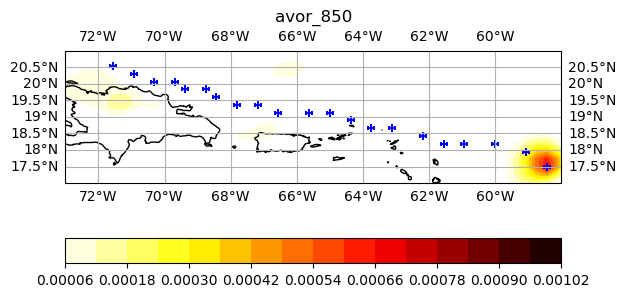

In [6]:
print(os.path.basename(files[filelist[0]]))
avor_850 = vor_850[:,257:-128,832:] * np.sign(lat)[None,257:-128,None]
avor_850_max = avor_850.max()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-73,-58,17,21), crs=ccrs.PlateCarree())
for ti in range(len(avor_850)):
    latid, lonid = np.unravel_index(np.argmax(avor_850[ti]), avor_850[ti].shape)
    avor_850_imax = avor_850[ti,latid,lonid]
    latid += 257; lonid += 832
    print(f"{time[ti]}: ({latid},{lonid}) - ({lat[latid]:.2f}N, {360-lon[lonid]:.2f}W) - {avor_850_imax:.5f} s-1")
    if ti == 0:
        plot = ax.contourf(lon[832:], lat[257:-128], avor_850[ti], 
                    levels=np.arange(6e-5, 1.03e-3, 6e-5), 
                    transform=ccrs.PlateCarree(),
                    cmap='hot_r')
    ax.scatter(lon[lonid], lat[latid], transform=ccrs.PlateCarree(), marker='+', c='b')
    ax.set_title('avor_850')

ax.gridlines(draw_labels=True)
ax.figure.colorbar(plot, orientation='horizontal')
ax.coastlines()
plt.show()
    

In [7]:
for time_i in range(len(time)):
    date_str = time[time_i].strftime('%Y-%m-%d')
    if os.path.exists(directory+'RV_Max/RV_Max_Coordinates_'+date_str+'.nc'):
        hour_counter	= 0
        print('skip creating RV_Max_Coordinates_'+date_str+'.nc (already exists)', flush=True)
        continue
    else:
        print(f"[{datetime.datetime.now()}] MFFile ids: {filelist}, step: {time_i+t0:03d} -> {date_str} ({t0:03d}-{t1:03d})", flush=True)
    
    #Loop over each 3-hourly field
    lat_index_EQ	= np.where(lat >= 0.0)[0][0]

    #Get all the indices where the (absolute) vorticity is larger than 6 * 10^-5 
    index_NH	= np.where(vor_850[time_i, lat_index_EQ:] >= RVTHRESHOLD)
    lat_index_NH	= index_NH[0] + lat_index_EQ
    lon_index_NH	= index_NH[1]
    index_SH	= np.where(-vor_850[time_i, :lat_index_EQ] >= RVTHRESHOLD)
    lat_index_SH	= index_SH[0]
    lon_index_SH	= index_SH[1]

    #Save all the indices in 1 array (SH + NH)
    lon_index	= np.insert(lon_index_SH, len(lon_index_SH), lon_index_NH)
    lat_index	= np.insert(lat_index_SH, len(lat_index_SH), lat_index_NH)

    #Save all the indices in 1 array (SH + NH)
    lon_index	= np.insert(lon_index_SH, len(lon_index_SH), lon_index_NH)
    lat_index	= np.insert(lat_index_SH, len(lat_index_SH), lat_index_NH)

    #-----------------------------------------------------------------------------------------
    #Empty arrays to save the RV maxima
    RV_max_index_lon	= []
    RV_max_index_lat	= []
    temp_anom		= []

    for index_i in range(len(lat_index)):
        #Loop over each point with a negative sea-level pressure
        lon_i		= lon_index[index_i]
        lat_i		= lat_index[index_i]

        #Check vorticity criterium
        vor_850_TC	= vor_850[time_i, lat_i, lon_i] * np.sign(lat[lat_i])
        vor_250_TC	= vor_250[time_i, lat_i, lon_i] * np.sign(lat[lat_i])

        if vor_850_TC < RVTHRESHOLD:
            #Relative vorticity is too low
            continue

        if (vor_850_TC - vor_250_TC) < RVDIFFTHRESHOLD:
            #No evidence for warm core
            continue

        #Get the horizontal velocity (8x8) around the eye
        lon_east	= lon_i + round(FIELDSIZE/(2*dlon)) + 1
        lon_west	= lon_i - round(FIELDSIZE/(2*dlon))
        lat_north	= lat_i + round(FIELDSIZE/(2*dlat)) + 1
        lat_south	= lat_i - round(FIELDSIZE/(2*dlat))

        if lat_south < 0:
            lat_south = 0

        #Get the dimensions for the lat field
        lat_field	= lat[lat_south:lat_north]
        weight		= lat_weight[lat_south:lat_north]
        weight		= weight / np.sum(weight)
        lon_field	= np.zeros(lon_east - lon_west)
        temp_field	= np.ma.masked_all((len(lat_field), len(lon_field)))
        U_10_field	= np.ma.masked_all((len(lat_field), len(lon_field)))

        if lon_east > len(lon):
            #Eastern part is on eastern hemisphere
            lon_1				= lon[lon_west:]
            lon_2				= lon[:lon_east - len(lon)] + 360.0
            lon_field[:len(lon_1)]		= lon_1
            lon_field[len(lon_1):]		= lon_2
            temp_field[:, :len(lon_1)]	= temp[time_i, lat_south:lat_north, lon_west:]
            temp_field[:, len(lon_1):]	= temp[time_i, lat_south:lat_north, :lon_east - len(lon)]
            U_10_field[:, :len(lon_1)]	= U_10[time_i, lat_south:lat_north, lon_west:]
            U_10_field[:, len(lon_1):]	= U_10[time_i, lat_south:lat_north, :lon_east - len(lon)]

        elif lon_west < 0:
            #Western part is on western hemisphere
            lon_1				= lon[lon_west:] - 360.0
            lon_2				= lon[:lon_east]
            lon_field[:len(lon_1)]		= lon_1
            lon_field[len(lon_1):]		= lon_2
            temp_field[:, :len(lon_1)]	= temp[time_i, lat_south:lat_north, lon_west:]
            temp_field[:, len(lon_1):]	= temp[time_i, lat_south:lat_north, :lon_east]
            U_10_field[:, :len(lon_1)]	= U_10[time_i, lat_south:lat_north, lon_west:]
            U_10_field[:, len(lon_1):]	= U_10[time_i, lat_south:lat_north, :lon_east]

        else:
            #Normal field can be retained
            lon_field	= lon[lon_west:lon_east]
            temp_field	= temp[time_i, lat_south:lat_north, lon_west:lon_east]
            U_10_field	= U_10[time_i, lat_south:lat_north, lon_west:lon_east]

        #Determine the spatial average over the field
        temp_mean	= np.mean(temp_field, axis = 1)
        temp_mean	= np.sum(temp_mean * weight)

        #Get the temperature anomaly of the given point
        lon_index_2 = (np.abs(lon_field - lon[lon_i])).argmin()
        lat_index_2 = (np.abs(lat_field - lat[lat_i])).argmin()
        temp_anom_TC	= temp_field[lat_index_2, lon_index_2] - temp_mean

        if temp_anom_TC < CORETEMPTHRESHOLD:
            #No warm core
            continue

        #Check whether the 10-m wind speed exceeds threshold 
        U_10_treshold = False

        for lat_j in range(len(lat_field)):
            for lon_j in range(len(lon_field)):
                #Check whether the 10-m wind speeds exceeds 10 m/s
                if U_10_field[lat_j, lon_j] < U10THRESHOLD:
                    continue

                #Check the 10-m wind speed in a 100-km search radius
                distance	= Distance(lon[lon_i], lat[lat_i], lon_field[lon_j], lat_field[lat_j]) / 1000.0

                if distance <= U10THRESHOLD_MAXRADIUS:
                    #10-m wind speed exceeds treshold within 100 km
                    U_10_treshold = True
                    break

            if U_10_treshold:
                #Threshold is reached, stop search
                break

        if U_10_treshold == False:
            #The 10-m wind speed treshold is not valid
            continue

        #Save the coordinates and the anomalies
        RV_max_index_lon.append(lon_i)
        RV_max_index_lat.append(lat_i)
        temp_anom.append(temp_anom_TC)

    #-----------------------------------------------------------------------------------------
    distance_RV = True
    RV_index_start	= 0

    while distance_RV:
        #Check RV maxima in the neighbourhood
        RV_dlat_min = np.ceil(1000*RVDISTMIN*180/(np.pi*RADIUSEARTH))
        for RV_i in range(RV_index_start, len(RV_max_index_lon)):
            for RV_j in range(RV_i + 1, len(RV_max_index_lon)):
                #Get the coordinates
                lon_RV_1	= lon[RV_max_index_lon[RV_i]]
                lat_RV_1	= lat[RV_max_index_lat[RV_i]]
                lon_RV_2	= lon[RV_max_index_lon[RV_j]]
                lat_RV_2	= lat[RV_max_index_lat[RV_j]]

                if np.abs(lat_RV_1 - lat_RV_2) > RV_dlat_min:
                    #Points are too far apart
                    continue

                #Determine the distance (km) between the two points
                distance	= Distance(lon_RV_1, lat_RV_1, lon_RV_2, lat_RV_2) / 1000.0

                if distance < RVDISTMIN:
                    #Distance between pressure minima must be at least 250 km
                    #Select the one with the lowest sea-level pressure
                    pres_1		= pres[time_i, RV_max_index_lat[RV_i], RV_max_index_lon[RV_i]]
                    pres_2		= pres[time_i, RV_max_index_lat[RV_j], RV_max_index_lon[RV_j]]

                    #Retain the one with the highest RV
                    index_min	= np.argmin([pres_1, pres_2])

                    if index_min == 0:
                        #First point has lowest PSL, remove second
                        RV_max_index_lon	= np.delete(RV_max_index_lon, RV_j)
                        RV_max_index_lat	= np.delete(RV_max_index_lat, RV_j)
                        temp_anom		= np.delete(temp_anom, RV_j)

                    else:
                        #Second point has lowest PSL, remove first
                        RV_max_index_lon	= np.delete(RV_max_index_lon, RV_i)
                        RV_max_index_lat	= np.delete(RV_max_index_lat, RV_i)
                        temp_anom		= np.delete(temp_anom, RV_i)

                    #Break the j-loop
                    RV_j = -1
                    break

            #Check whether the j-loop was terminated
            if RV_j == -1:
                #Break i-loop and start over with the reduced list
                RV_j = 0
                break

            else:
                #j-loop is completed, raise starting index by 1
                RV_index_start += 1

            if RV_i == len(RV_max_index_lon) - 1:
                #i-loop is finished, stop the while
                distance_RV = False


    #-----------------------------------------------------------------------------------------

    #Save the indices (note that the index has a base starting at 60S)
    time_RV_max[hour_counter]				= cftime.date2num(time[time_i], 'Days since 0001-01-01 00:00:00 UTC', 'noleap')
    RV_max_coor_lon[hour_counter, :len(RV_max_index_lon)]	= RV_max_index_lon
    RV_max_coor_lat[hour_counter, :len(RV_max_index_lat)]	= RV_max_index_lat
    temp_anom_all[hour_counter, :len(temp_anom)]		= temp_anom

    if len(RV_max_index_lon) > RV_max_max_day:
        #New hourly maximum of pressure minima
        RV_max_max_day = len(RV_max_index_lon)

    #Update hour counter
    hour_counter += 1

    if hour_counter == NOUT:
        #Remove masked arrays
        RV_max_coor_lon		= RV_max_coor_lon[:, :RV_max_max_day + 1]
        RV_max_coor_lat		= RV_max_coor_lat[:, :RV_max_max_day + 1]
        temp_anom_all		= temp_anom_all[:, :RV_max_max_day + 1]

        # write data
        HEAT_data = netcdf.Dataset(directory+'RV_Max/RV_Max_Coordinates_'+date_str+'.nc', 'w')
        HEAT_data.createDimension('time', len(time_RV_max))
        HEAT_data.createDimension('number_lows', len(RV_max_coor_lon[0]))
        HEAT_data.createVariable('time', float, ('time'), zlib=True)
        HEAT_data.createVariable('number_lows', float, ('number_lows'), zlib=True)
        HEAT_data.createVariable('lon_index', float, ('time', 'number_lows'), zlib=True)
        HEAT_data.createVariable('lat_index', float, ('time', 'number_lows'), zlib=True)
        HEAT_data.createVariable('TEMP', float, ('time', 'number_lows'), zlib=True)
        HEAT_data.variables['lon_index'].longname	= 'Longitude index of low'
        HEAT_data.variables['lat_index'].longname	= 'Latitude index of low (0 = 60.2S)'
        HEAT_data.variables['TEMP'].longname		= 'Temperature anomaly w.r.t. 8x8 mean'
        HEAT_data.variables['time'].units		= 'Days since 0001-01-01 00:00:00 UTC'
        HEAT_data.variables['time'].calendar	= 'noleap'
        HEAT_data.variables['TEMP'].units		= 'deg C'	
        HEAT_data.variables['time'][:]			= time_RV_max
        HEAT_data.variables['number_lows'][:]	= np.arange(len(RV_max_coor_lon[0])) + 1
        HEAT_data.variables['lon_index'][:]		= RV_max_coor_lon
        HEAT_data.variables['lat_index'][:]		= RV_max_coor_lat
        HEAT_data.variables['TEMP'][:]			= temp_anom_all
        print("Created {}".format(HEAT_data.filepath()), flush=True)
        HEAT_data.close()
        

        #Reset the counters
        hour_counter	= 0
        RV_max_max_day	= 0
    
        #Make empty array for the following day
        time_RV_max		= np.ma.masked_all(NOUT)
        RV_max_coor_lon = np.ma.masked_all((NOUT, 800))
        RV_max_coor_lat = np.ma.masked_all((NOUT, 800))
        temp_anom_all	= np.ma.masked_all((NOUT, 800))


[2024-10-31 11:37:21.837333] MFFile ids: [0], step: 014 -> 2093-09-23 (014-035)
[2024-10-31 11:38:27.362517] MFFile ids: [0], step: 015 -> 2093-09-24 (014-035)
[2024-10-31 11:39:35.533125] MFFile ids: [0], step: 016 -> 2093-09-24 (014-035)
[2024-10-31 11:40:41.962307] MFFile ids: [0], step: 017 -> 2093-09-24 (014-035)
[2024-10-31 11:41:45.678715] MFFile ids: [0], step: 018 -> 2093-09-24 (014-035)
[2024-10-31 11:42:47.653141] MFFile ids: [0], step: 019 -> 2093-09-24 (014-035)
[2024-10-31 11:43:49.068388] MFFile ids: [0], step: 020 -> 2093-09-24 (014-035)
[2024-10-31 11:44:53.776995] MFFile ids: [0], step: 021 -> 2093-09-24 (014-035)
Created /home/jasperdj/files_rene/RCP.started_2092.001.test/RV_Max/RV_Max_Coordinates_2093-09-24.nc
skip creating RV_Max_Coordinates_2093-09-24.nc (already exists)
[2024-10-31 11:46:00.224289] MFFile ids: [0], step: 023 -> 2093-09-25 (014-035)
[2024-10-31 11:47:10.162616] MFFile ids: [0], step: 024 -> 2093-09-25 (014-035)
[2024-10-31 11:48:18.719679] MFFile 

In [ ]:
2093-09-23 21:00:00: (331,965) - (17.48N, 58.44W) - 0.00066 s-1
2093-09-24 00:00:00: (333,963) - (17.95N, 59.06W) - 0.00075 s-1
2093-09-24 03:00:00: (334,960) - (18.19N, 60.00W) - 0.00084 s-1
2093-09-24 06:00:00: (334,957) - (18.19N, 60.94W) - 0.00091 s-1
2093-09-24 09:00:00: (334,955) - (18.19N, 61.56W) - 0.00097 s-1
2093-09-24 12:00:00: (335,953) - (18.42N, 62.19W) - 0.00091 s-1
2093-09-24 15:00:00: (336,950) - (18.66N, 63.12W) - 0.00085 s-1
2093-09-24 18:00:00: (336,948) - (18.66N, 63.75W) - 0.00089 s-1
2093-09-24 21:00:00: (337,946) - (18.89N, 64.38W) - 0.00102 s-1
2093-09-25 00:00:00: (338,944) - (19.13N, 65.00W) - 0.00091 s-1
2093-09-25 03:00:00: (338,942) - (19.13N, 65.62W) - 0.00088 s-1
2093-09-25 06:00:00: (338,939) - (19.13N, 66.56W) - 0.00084 s-1
2093-09-25 09:00:00: (339,937) - (19.36N, 67.19W) - 0.00099 s-1
2093-09-25 12:00:00: (339,935) - (19.36N, 67.81W) - 0.00096 s-1
2093-09-25 15:00:00: (340,933) - (19.60N, 68.44W) - 0.00098 s-1
2093-09-25 18:00:00: (341,932) - (19.83N, 68.75W) - 0.00092 s-1
2093-09-25 21:00:00: (341,930) - (19.83N, 69.38W) - 0.00095 s-1
2093-09-26 00:00:00: (342,929) - (20.07N, 69.69W) - 0.00079 s-1
2093-09-26 03:00:00: (342,927) - (20.07N, 70.31W) - 0.00078 s-1
2093-09-26 06:00:00: (343,925) - (20.30N, 70.94W) - 0.00078 s-1
2093-09-26 09:00:00: (344,923) - (20.53N, 71.56W) - 0.00067 s-1

In [45]:
fh = netcdf.Dataset('/home/jasperdj/files_rene/RCP.started_2092.001.test/RV_Max/RV_Max_Coordinates_2093-09-25.nc','r')
cftime.num2date(fh['time'][:], fh['time'].units, fh['time'].calendar)

masked_array(data=[cftime.DatetimeNoLeap(2093, 9, 25, 0, 0, 0, 0, has_year_zero=True),
                   cftime.DatetimeNoLeap(2093, 9, 25, 3, 0, 0, 0, has_year_zero=True),
                   cftime.DatetimeNoLeap(2093, 9, 25, 6, 0, 0, 0, has_year_zero=True),
                   cftime.DatetimeNoLeap(2093, 9, 25, 9, 0, 0, 0, has_year_zero=True),
                   cftime.DatetimeNoLeap(2093, 9, 25, 12, 0, 0, 0, has_year_zero=True),
                   cftime.DatetimeNoLeap(2093, 9, 25, 15, 0, 0, 0, has_year_zero=True),
                   cftime.DatetimeNoLeap(2093, 9, 25, 18, 0, 0, 0, has_year_zero=True),
                   cftime.DatetimeNoLeap(2093, 9, 25, 21, 0, 0, 0, has_year_zero=True)],
             mask=False,
       fill_value='?',
            dtype=object)

In [47]:
def chunk_data(files):
	"""divide data into daily chunks"""
	n = 0 
	with netcdf.Dataset(files[0],'r') as fh:
# 		time = fh.variables['time'][:]
		time = fh['time_bnds'][:].mean(axis=-1)
# 		if 'time: mean' in # getattr(fh['U850'], 'cell_methods', ''):
# 			time = time - 0.5*dt
		dates = [cftime.num2date(t, fh['time'].units, fh['time'].calendar).strftime("%Y%m%d") for t in time]
		chunks = [[dates[0],[0],0,0]]
	for fid in range(len(files)):
		with netcdf.Dataset(files[fid],'r') as fh:
# 			time = fh.variables['time'][:]
			time = fh['time_bnds'][:].mean(axis=-1)
# 			if 'time: mean' in getattr(fh['U850'], 'cell_methods', ''):
# 				time = time - 0.5*dt
			dates = [cftime.num2date(t, fh['time'].units, fh['time'].calendar).strftime("%Y%m%d") for t in time]
			for i,newdate in enumerate(dates):
				(olddate, fids0, i0, n0) = chunks[-1]
				if newdate != olddate:
					if fids0[-1] != fid and i!=0:
						chunks[-1][1].append(fid)
					chunks[-1][3] = i0 + n - n0
					chunks.append([newdate,[fid],i,n])
				n += 1
	(olddate, fids0, i0, n0) = chunks[-1]
	chunks[-1][3] = i0 + n - n0
	return chunks

In [49]:
chunk_data(files)

[['20930922', [0], 0, 8],
 ['20930923', [0], 8, 16],
 ['20930924', [0], 16, 24],
 ['20930925', [0], 24, 32],
 ['20930926', [0], 32, 40]]

In [64]:
experiment_name_ = 'hres_b.e10.B2000_CAM5.f02_t12.started_'+str(run_year_start)+'-12.'+str(run_ensemble).zfill(3)
directory_data_  = '/projects/0/nwo2021025/archive/'+experiment_name_+'/atm/hist/'
files = glob.glob(directory_data_+experiment_name_+'.cam2.'+'h5'+'.*.nc')
files.sort() #Sort the files on date

In [66]:
chunk_data(files[1:3])

[['20930106', [0], 0, 4],
 ['20930107', [0], 4, 12],
 ['20930108', [0], 12, 20],
 ['20930109', [0], 20, 28],
 ['20930110', [0], 28, 36],
 ['20930111', [0], 36, 44],
 ['20930112', [0], 44, 52],
 ['20930113', [0], 52, 60],
 ['20930114', [0], 60, 68],
 ['20930115', [0], 68, 76],
 ['20930116', [0], 76, 84],
 ['20930117', [0], 84, 92],
 ['20930118', [0], 92, 100],
 ['20930119', [0], 100, 108],
 ['20930120', [0], 108, 116],
 ['20930121', [0], 116, 124],
 ['20930122', [0], 124, 132],
 ['20930123', [0], 132, 140],
 ['20930124', [0], 140, 148],
 ['20930125', [0], 148, 156],
 ['20930126', [0], 156, 164],
 ['20930127', [0], 164, 172],
 ['20930128', [0], 172, 180],
 ['20930129', [0], 180, 188],
 ['20930130', [0], 188, 196],
 ['20930131', [0], 196, 204],
 ['20930201', [0], 204, 212],
 ['20930202', [0], 212, 220],
 ['20930203', [0], 220, 228],
 ['20930204', [0], 228, 236],
 ['20930205', [0], 236, 244],
 ['20930206', [0], 244, 252],
 ['20930207', [0], 252, 260],
 ['20930208', [0], 260, 268],
 ['20930